# Capstone 2: Exploratory Data Analysis (EDA)

This notebook encompasses the EDA portion of my second capstone project. The problem I am trying to solve for is how can I use the UCI Heart Disease Dataset (https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data?resource=download) to predict someone's risk of developing heart disease?

### Library imports and jupyter notebook settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
%matplotlib inline

### Functions used in analysis

In [2]:
def get_avg_by_num(dataset, var):
    print(var)
    means = dataset.groupby('num')[var].mean()
    print(means)
    print(f'{(means[1] - means[0]) / dataset[var].std():.2f} std dev')
    print('')
def get_boxplots(dataset, col_names, num_boxplot_cols):
    df = dataset.melt(id_vars='num', value_vars=col_names)
    g = sns.catplot(
        data=df, 
        y='value', 
        x='variable', 
        hue='num', 
        kind='box', 
        col_wrap=num_boxplot_cols, 
        col='variable', 
        sharex=False,
        sharey=False)
    g.set_titles('{col_name}')
    g.tight_layout()
def get_t_test(dataset, var, bonferroni_correction):
    data = dataset[[var, 'num']]
    no_hd = data[data['num']==0]
    hd = data[data['num']==1]
    t_stat, p_value = ttest_ind(no_hd[var].dropna(), hd[var].dropna())
    print(var)
    print("t-statistic = " + str(t_stat))  
    print("p-value = " + str(p_value)) 
    print("adjusted p-value = " + str(p_value * bonferroni_correction)) 
    print('')
def get_correlation_coefficient(dataset, var):
    df = dataset[[var, 'num']]
    df = df.dropna()
    correlation_coeff = df[var].corr(df['num'])
    print(f'Correlation coefficient - {var} and num: {correlation_coeff}')
def get_counts_by_num(dataset, var):
    print(var)
    print(dataset.groupby('num')[var].value_counts().sort_index())
    print('')  
def get_stacked_barcharts(dataset, columns):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(columns, start=1):
        plt.subplot(3, 3, i)
        counts = dataset.groupby('num')[col].value_counts().unstack().T
        percentages = counts.div(counts.sum(axis=0), axis=1) * 100
        ax = percentages.T.plot(kind='bar', stacked=True, ax=plt.gca(), color=['blue', 'orange'])
        # Set the title and labels
        plt.title(f'Pct {col} by Heart Disease or No Heart Disease')
        plt.xlabel('')
        plt.ylabel('Percentage')
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy()
            ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center', fontweight='bold')
    # Adjust the layout
    plt.tight_layout()
def get_chi_square(dataset, var, bonferroni_correction):
    data = dataset[[var, 'num']]
    data = data.dropna()
    contingency_table = pd.crosstab(data['num'], data[var])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print(var)
    print("chi2 = " + str(chi2))  
    print("p-value = " + str(p_value)) 
    print("adjusted p-value = " + str(p_value * bonferroni_correction)) 
    print('')

### Read in "Heart Disease - All Datasets" and "Heart Disease - Cleveland Dataset"

Two datasets are being examined in the analysis:

1) All Heart Disease Locations Dataset
2) Cleveland Location Heart Disease Dataset

The first of these datasets is composed of data from four different locations: Cleveland, Switzerland, VA Long Beach, and Hungary and is a subset of the columns in the Cleveland only dataset.

In [3]:
all_hd_data = pd.read_csv('../data/interim/heart_disease_data_all.csv')
cleveland_hd_data = pd.read_csv('../data/interim/heart_disease_data_cleveland.csv')

# Heart Disease - All Datasets

### Get info on dataset (column names, number of non-null values, and datatypes)

In [4]:
all_hd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  865 non-null    int64  
 1   id          865 non-null    int64  
 2   age         865 non-null    int64  
 3   sex         865 non-null    object 
 4   dataset     865 non-null    object 
 5   cp          865 non-null    object 
 6   trestbps    860 non-null    float64
 7   chol        677 non-null    float64
 8   fbs         776 non-null    object 
 9   restecg     863 non-null    object 
 10  thalch      864 non-null    float64
 11  exang       864 non-null    object 
 12  oldpeak     846 non-null    float64
 13  num         865 non-null    int64  
dtypes: float64(4), int64(4), object(6)
memory usage: 94.7+ KB


### View data

In [5]:
all_hd_data = all_hd_data.drop('Unnamed: 0', axis=1)
all_hd_data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0


Taking a look at the info in the dataset, we see that there are 865 entries and 13 actual columns (one patient id, one dataset id, five numerical variables, five categorical variables, and one target feature).

## Numerical Variables

### Statistical description of numerical variables (count, mean, std, min, max, percentiles)

In [6]:
all_hd_data[['age', 'trestbps', 'chol', 'thalch', 'oldpeak']].describe()

,age,trestbps,chol,thalch,oldpeak
count,865.000000,860.000000,677.000000,864.000000,846.000000
mean,53.150289,132.286047,247.128508,137.554398,0.906265
std,9.374319,18.536175,58.646265,25.940020,1.071192
min,28.000000,80.000000,85.000000,60.000000,0.000000
25%,46.000000,120.000000,210.000000,120.000000,0.000000
50%,54.000000,130.000000,240.000000,140.000000,0.500000
75%,60.000000,140.000000,276.000000,157.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


### Mean values of numerical variables by "Heart Disease" or "No Heart Disease"

In [7]:
print('Mean values by Heart Disease or No Heart Disease:')
for var in ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']:
    get_avg_by_num(all_hd_data, var)

Mean values by Heart Disease or No Heart Disease:
age
num
0    50.196429
1    55.598309
Name: age, dtype: float64
0.58 std dev

trestbps
num
0    129.913043
1    134.264392
Name: trestbps, dtype: float64
0.23 std dev

chol
num
0    240.809524
1    254.178125
Name: chol, dtype: float64
0.23 std dev

thalch
num
0    148.800512
1    128.257928
Name: thalch, dtype: float64
-0.79 std dev

oldpeak
num
0    0.425840
1    1.311329
Name: oldpeak, dtype: float64
0.83 std dev



All five of the numerical variables have a pretty sizable difference in means between the "Heart Disease" and "No Heart Disease" groups, and thalch is the only variable that has a lower mean in the "Heart Disease" group. The biggest differences (in terms of standard deviations difference) are for the oldpeak (0.83 standard deviations), thalch (-0.79 standard deviations), and age variables (0.58 standard deviations).

### Boxplots of numerical variables

Heart Disease vs. No Heart Disease


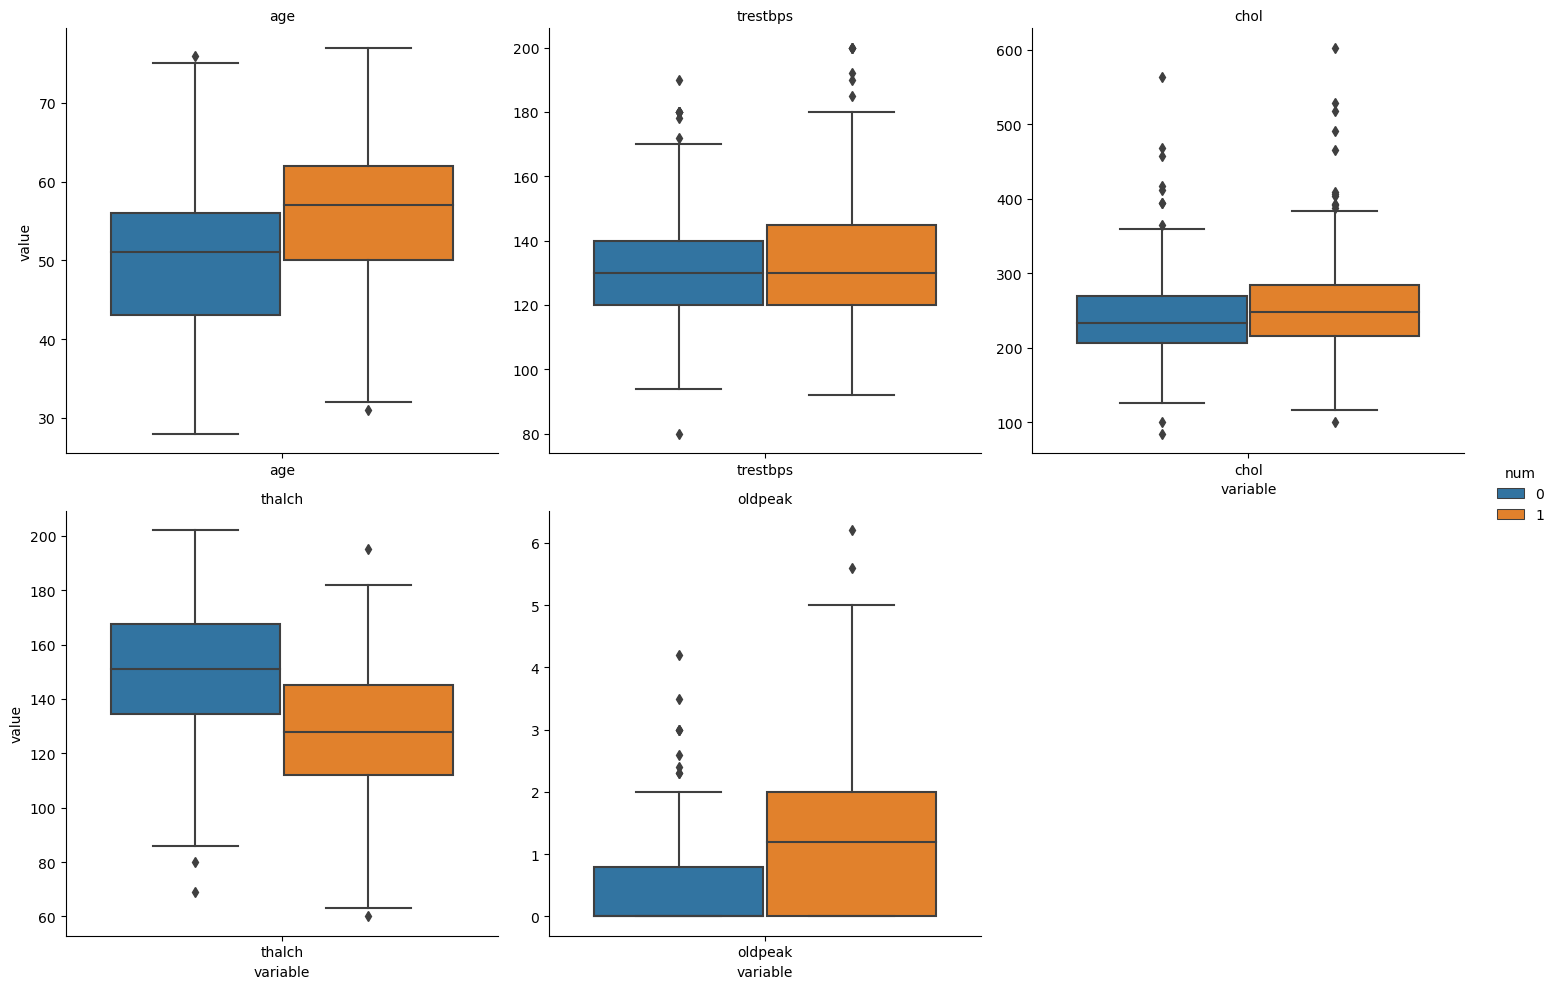

In [8]:
cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
print('Heart Disease vs. No Heart Disease')
get_boxplots(all_hd_data, cols, 3)

Viewing the boxplots confirms what we've seen numerically with our mean comparisons. Also, while there are a few outliers, they all appear to be valid data values within the bounds of what could be possible.

### T-tests of numerical variables ("Heart Disease" vs. "No Heart Disease")

In [9]:
bonferroni_correction = 5
print('T-tests for numerical variables:')
for var in ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']:
    get_t_test(all_hd_data, var, bonferroni_correction)

T-tests for numerical variables:
age
t-statistic = -8.802137337956179
p-value = 7.23213989584215e-18
adjusted p-value = 3.616069947921075e-17

trestbps
t-statistic = -3.4495889561945443
p-value = 0.0005888105614081387
adjusted p-value = 0.0029440528070406933

chol
t-statistic = -2.9783378528506734
p-value = 0.003002089742279435
adjusted p-value = 0.015010448711397175

thalch
t-statistic = 12.601123785652042
p-value = 1.5409194381749777e-33
adjusted p-value = 7.704597190874888e-33

oldpeak
t-statistic = -13.138423334675661
p-value = 5.2130735040711185e-36
adjusted p-value = 2.6065367520355594e-35



I conducted five one-way independent sample t-tests to see if the means in the "Heart Disease" group were significantly different than the means in the "No Heart Disease" group. Because there were five tests, I included an adjusted p-value that accounts for the increased chance of a false positive. All five variables had an adjusted p-value of less than .05, and four of the five had an adjusted p-value of less than .01. Age, thalch, and oldpeak had p-values of effectively 0.

### Correlation coefficients for numerical variables vs. target feature

In [10]:
print('Correlation coefficients - numerical features')
for var in ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']:
    get_correlation_coefficient(all_hd_data, var)

Correlation coefficients - numerical features
Correlation coefficient - age and num: 0.2870211547789398
Correlation coefficient - trestbps and num: 0.11695876323429297
Correlation coefficient - chol and num: 0.11389037613990423
Correlation coefficient - thalch and num: -0.39440410966471523
Correlation coefficient - oldpeak and num: 0.41206366212407886


Looking at the correlation coefficients between the five numerical variables and the target feature, we see positive correlations in four of the five relationships (thalch and num being the only negative one). The strongest correlations are the same as what we've observed above (age, thalch, and oldpeak).

## Categorical variables

### Counts of categorical variables for "Heart Disease" or "No Heart Disease"

In [11]:
print('Counts by Heart Disease or No Heart Disease:')
for var in ['sex', 'cp', 'fbs', 'restecg', 'exang']:
    get_counts_by_num(all_hd_data, var)

Counts by Heart Disease or No Heart Disease:
sex
num  sex   
0    Female    143
     Male      249
1    Female     50
     Male      423
Name: sex, dtype: int64

cp
num  cp             
0    asymptomatic        99
     atypical angina    145
     non-anginal        125
     typical angina      23
1    asymptomatic       370
     atypical angina     23
     non-anginal         61
     typical angina      19
Name: cp, dtype: int64

fbs
num  fbs  
0    False    338
     True      40
1    False    321
     True      77
Name: fbs, dtype: int64

restecg
num  restecg         
0    lv hypertrophy       79
     normal              261
     st-t abnormality     52
1    lv hypertrophy      102
     normal              270
     st-t abnormality     99
Name: restecg, dtype: int64

exang
num  exang
0    False    336
     True      55
1    False    192
     True     281
Name: exang, dtype: int64



When looking at the categorical variables, I realized I could simplify the interpretation of my model by changing each of them to a binary response. For 'cp' this meant coding the responses as "Has Chest Pain" or "Does Not Have Chest Pain", and for 'restecg' it meant coding the responses as "Abnormal Resting ECG" or "Normal Resting ECG".

### Replacement of categorical variable responses with binary responses

In [12]:
all_hd_data['Male'] = all_hd_data['sex'].apply(lambda x: 1 if x == 'Male' else 0)
all_hd_data['chest_pain'] = all_hd_data['cp'].apply(lambda x: 1 if x != 'asymptomatic' else 0)
all_hd_data['high_fbs'] = all_hd_data['fbs'].apply(lambda x: 1 if x == True else 0)
all_hd_data['abnormal_restecg'] = all_hd_data['restecg'].apply(lambda x: 1 if x != 'normal' else 0)
all_hd_data['exercise_induced_angina'] = all_hd_data['exang'].apply(lambda x: 1 if x == True else 0)
all_hd_data = all_hd_data.drop(['sex', 'cp', 'fbs', 'restecg', 'exang', 'dataset'], axis=1)

### Mean values of categorical variables by "Heart Disease" or "No Heart Disease"

In [13]:
for var in ['Male', 'chest_pain', 'high_fbs', 'abnormal_restecg', 'exercise_induced_angina']:
    get_avg_by_num(all_hd_data, var)

Male
num
0    0.635204
1    0.894292
Name: Male, dtype: float64
0.62 std dev

chest_pain
num
0    0.747449
1    0.217759
Name: chest_pain, dtype: float64
-1.06 std dev

high_fbs
num
0    0.102041
1    0.162791
Name: high_fbs, dtype: float64
0.18 std dev

abnormal_restecg
num
0    0.334184
1    0.429175
Name: abnormal_restecg, dtype: float64
0.19 std dev

exercise_induced_angina
num
0    0.140306
1    0.594080
Name: exercise_induced_angina, dtype: float64
0.93 std dev



Since all of the categorical columns could be coded as 0 or 1, I was able to look at the means between the two groups ("Heart Disease" and "No Heart Disease"). All five of the categorical variables had a pretty sizable difference in means between the "Heart Disease" and "No Heart Disease" groups, and chest_pain is the only variable that has a lower mean in the "Heart Disease" group. This surprised me, but makes sense since heart disease is often called the "silent killer". The biggest differences (in terms of standard deviations difference) are for the chest_pain (-1.06 standard deviations), exercise_induced_angina (0.93 standard deviations), and Male (0.62 standard deviations) variables.

### Stacked barcharts of categorical variables by response and target feature

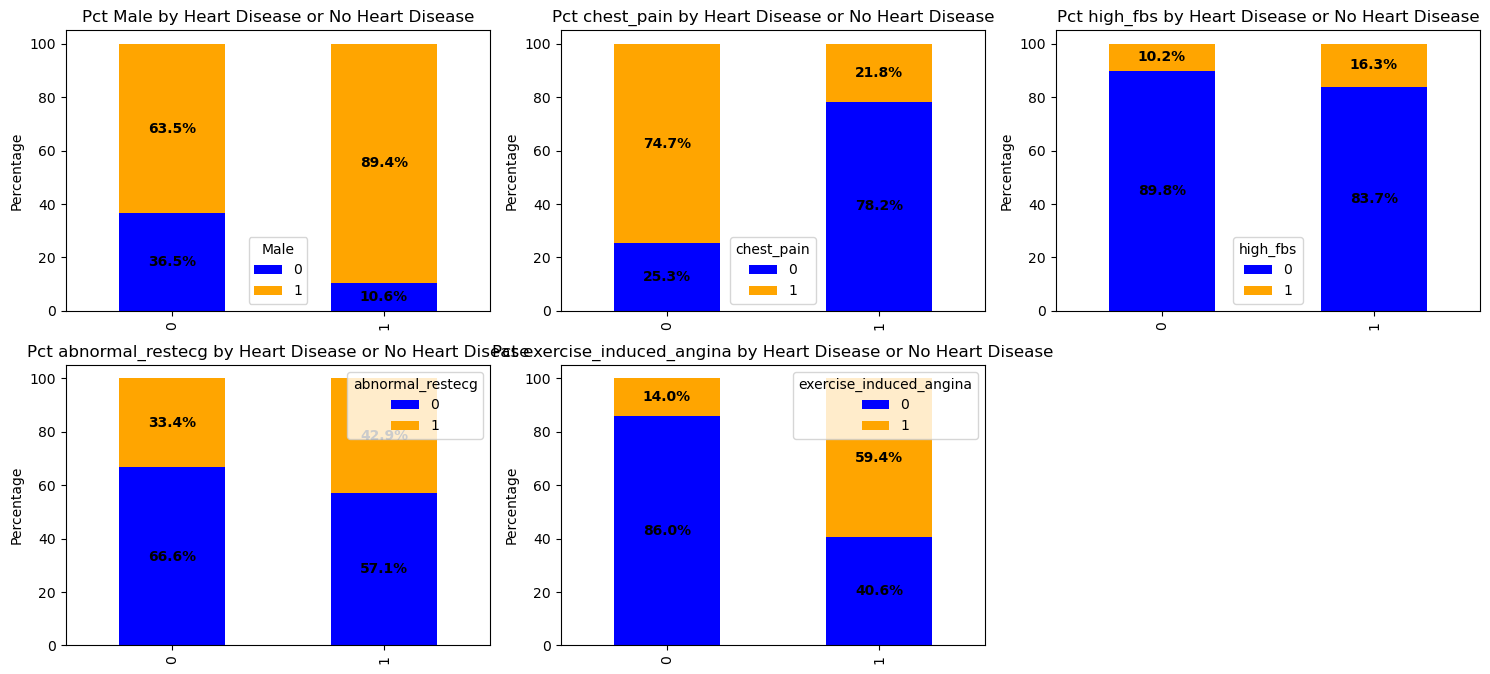

In [14]:
get_stacked_barcharts(all_hd_data, ['Male', 'chest_pain', 'high_fbs', 'abnormal_restecg', 'exercise_induced_angina'])

### Chi-square tests of categorical variables ("Heart Disease" vs. "No Heart Disease")

In [15]:
bonferroni_correction = 5
for var in ['Male', 'chest_pain', 'high_fbs', 'abnormal_restecg', 'exercise_induced_angina']:
    get_chi_square(all_hd_data, var, bonferroni_correction)

Male
chi2 = 81.52199981971084
p-value = 1.7332142389186592e-19
adjusted p-value = 8.666071194593296e-19

chest_pain
chi2 = 240.16260102925793
p-value = 3.6245266079463536e-54
adjusted p-value = 1.8122633039731769e-53

high_fbs
chi2 = 6.254011106865534
p-value = 0.012391240184098498
adjusted p-value = 0.06195620092049249

abnormal_restecg
chi2 = 7.7642499782034955
p-value = 0.005329042038575444
adjusted p-value = 0.02664521019287722

exercise_induced_angina
chi2 = 183.89569534936948
p-value = 6.837243597548012e-42
adjusted p-value = 3.4186217987740056e-41



I conducted five chi-squared tests to see if the number of responses in each category were different in the "Heart Disease" group vs. the "No Heart Disease" group. Because there were five tests, I included an adjusted p-value that accounts for the increased chance of a false positive. Four of the five variables had an adjusted p-value of less than .05 (high_fbs did not), and three of the five had p-values of effectively 0 (Male, chest_pain, and exercise_induced_angina).

### Correlation coefficients for categorical variables vs. target feature

In [16]:
print('Correlation coefficients - binary features')
for var in ['Male', 'chest_pain', 'high_fbs', 'abnormal_restecg', 'exercise_induced_angina']:
    get_correlation_coefficient(all_hd_data, var)

Correlation coefficients - binary features
Correlation coefficient - Male and num: 0.3097826306622782
Correlation coefficient - chest_pain and num: -0.5292505998778834
Correlation coefficient - high_fbs and num: 0.08842504878948886
Correlation coefficient - abnormal_restecg and num: 0.09712683507533981
Correlation coefficient - exercise_induced_angina and num: 0.4634639344159409


Looking at the correlation coefficients between the five categorical variables and the target feature, we see positive correlations in four of the five relationships (chest_pain and num being the only negative one). The strongest correlations are the same as what we've observed above (Male, chest_pain, and exercise_induced_angina).

## All variables

### Correlation coefficient heatmap

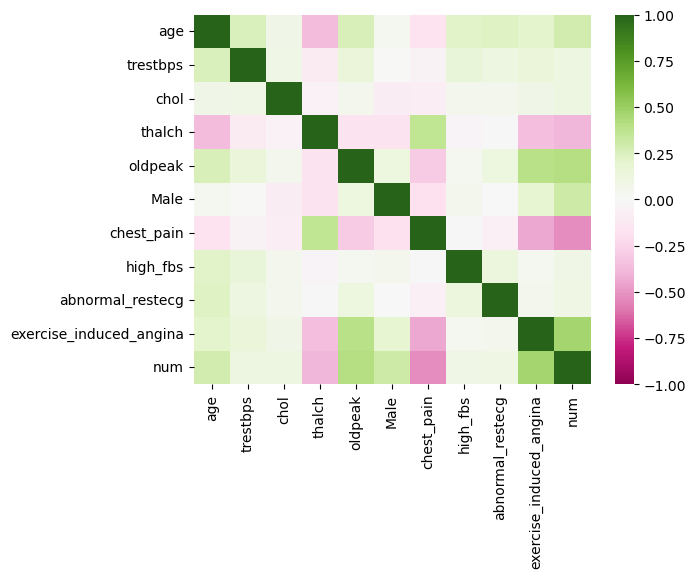

In [17]:
sns.heatmap(all_hd_data[['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'Male', 'chest_pain', 
                         'high_fbs', 'abnormal_restecg', 'exercise_induced_angina', 'num']].corr(), 
            vmin=-1, vmax=1,cmap='PiYG');

The correlation coefficient heatmap highlights some of the observations from above. It also shows that some of our variables are not entirely independent of one another, which we might want to keep an eye on going forward.

# Heart Disease - Cleveland Dataset

### Get info on dataset (column names, number of non-null values, and datatypes)

In [18]:
cleveland_hd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  304 non-null    int64  
 1   id          304 non-null    int64  
 2   age         304 non-null    int64  
 3   sex         304 non-null    object 
 4   dataset     304 non-null    object 
 5   cp          304 non-null    object 
 6   trestbps    304 non-null    float64
 7   chol        304 non-null    float64
 8   fbs         304 non-null    bool   
 9   restecg     304 non-null    object 
 10  thalch      304 non-null    float64
 11  exang       304 non-null    bool   
 12  oldpeak     304 non-null    float64
 13  slope       303 non-null    object 
 14  ca          299 non-null    float64
 15  thal        301 non-null    object 
 16  num         304 non-null    int64  
dtypes: bool(2), float64(5), int64(4), object(6)
memory usage: 36.3+ KB


### View data

In [19]:
cleveland_hd_data = cleveland_hd_data.drop('Unnamed: 0', axis=1)
cleveland_hd_data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


Taking a look at the info in the dataset, we see that there are 304 entries and 16 actual columns (one patient id, one dataset id, six numerical variables, seven categorical variables, and one target feature).

## Numerical Variables

### Statistical description of numerical variables (count, mean, std, min, max, percentiles)

In [20]:
cleveland_hd_data[['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']].describe()

,age,trestbps,chol,thalch,oldpeak,ca
count,304.000000,304.000000,304.000000,304.000000,304.000000,299.000000
mean,54.351974,131.684211,246.315789,149.723684,1.036184,0.672241
std,9.150256,17.570949,52.108280,22.927263,1.160690,0.937438
min,28.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,47.750000,120.000000,211.000000,133.750000,0.000000,0.000000
50%,55.500000,130.000000,240.500000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000


### Mean values of numerical variables by "Heart Disease" or "No Heart Disease"

In [21]:
print('Mean values by Heart Disease or No Heart Disease:')
for var in ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']:
    get_avg_by_num(cleveland_hd_data, var)

Mean values by Heart Disease or No Heart Disease:
age
num
0    52.436364
1    56.625899
Name: age, dtype: float64
0.46 std dev

trestbps
num
0    129.254545
1    134.568345
Name: trestbps, dtype: float64
0.30 std dev

chol
num
0    241.969697
1    251.474820
Name: chol, dtype: float64
0.18 std dev

thalch
num
0    158.539394
1    139.258993
Name: thalch, dtype: float64
-0.84 std dev

oldpeak
num
0    0.583030
1    1.574101
Name: oldpeak, dtype: float64
0.85 std dev

ca
num
0    0.273292
1    1.137681
Name: ca, dtype: float64
0.92 std dev



All six of the numerical variables have a pretty sizable difference in means between the "Heart Disease" and "No Heart Disease" groups, and thalch is the only variable that has a lower mean in the "Heart Disease" group. The biggest differences (in terms of standard deviations difference) are for the ca (0.92 standard deviations), oldpeak (0.85 standard deviations), and thalch variables (-0.84 standard deviations).

### Boxplots of numerical variables

Heart Disease vs. No Heart Disease


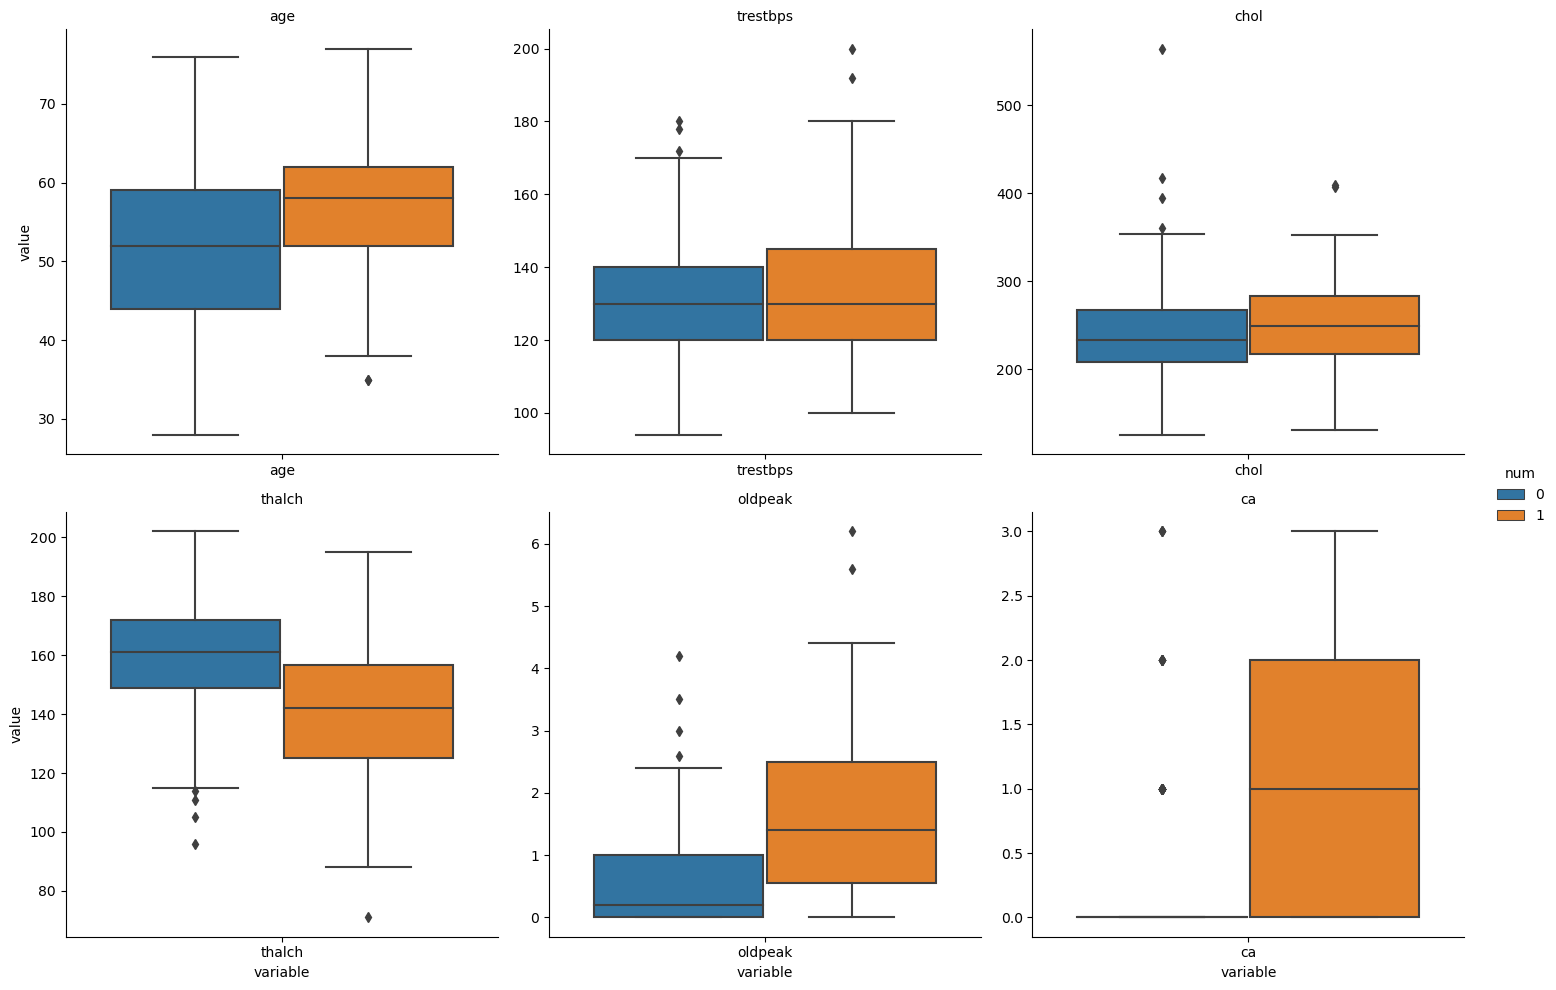

In [22]:
cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
print('Heart Disease vs. No Heart Disease')
get_boxplots(cleveland_hd_data, cols, 3)

Viewing the boxplots confirms what we've seen numerically with our mean comparisons. While there are a few outliers in the chol variable that could be invalid data, it's possible they are valid values so we'll keep them in our analysis.

### T-tests of numerical variables ("Heart Disease" vs. "No Heart Disease")

In [23]:
bonferroni_correction = 6
print('T-tests for numerical variables:')
for var in ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']:
    get_t_test(cleveland_hd_data, var, bonferroni_correction)

T-tests for numerical variables:
age
t-statistic = -4.078198773775262
p-value = 5.811149554984855e-05
adjusted p-value = 0.0003486689732990913

trestbps
t-statistic = -2.6528139320330646
p-value = 0.008404480862122001
adjusted p-value = 0.05042688517273201

chol
t-statistic = -1.5883721770795753
p-value = 0.11324855513729683
adjusted p-value = 0.679491330823781

thalch
t-statistic = 8.03370903668964
p-value = 2.142445440468379e-14
adjusted p-value = 1.2854672642810274e-13

oldpeak
t-statistic = -8.184324036699392
p-value = 7.743511486560228e-15
adjusted p-value = 4.6461068919361365e-14

ca
t-statistic = -8.939073929229622
p-value = 4.268994667778772e-17
adjusted p-value = 2.561396800667263e-16



I conducted six one-way independent sample t-tests to see if the means in the "Heart Disease" group were significantly different than the means in the "No Heart Disease" group. Because there were six tests, I included an adjusted p-value that accounts for the increased chance of a false positive. Four of the six variables had an adjusted p-value of less than .01, and thalch, oldpeak, and ca had p-values of effectively 0.

While cholesterol is not significant (even without adjusting the p-value), I am choosing to keep it for further analysis. It could interact with other variables and the fact that it directionally makes sense means that it could provide useful information. If it's not useful, we can discard it later.

### Correlation coefficients for numerical variables vs. target feature

In [24]:
print('Correlation coefficients - numerical features')
for var in ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']:
    get_correlation_coefficient(cleveland_hd_data, var)

Correlation coefficients - numerical features
Correlation coefficient - age and num: 0.22846721927004804
Correlation coefficient - trestbps and num: 0.15090417443255139
Correlation coefficient - chol and num: 0.09102114070934685
Correlation coefficient - thalch and num: -0.4196189820099138
Correlation coefficient - oldpeak and num: 0.42606861347184966
Correlation coefficient - ca and num: 0.4604424994712623


Looking at the correlation coefficients between the six numerical variables and the target feature, we see positive correlations in five of the six relationships (thalch and num being the only negative one). The strongest correlations are the same as what we've observed above (thalch, oldpeak, and ca).

## Categorical variables

### Counts of categorical variables for "Heart Disease" or "No Heart Disease"

In [25]:
print('Counts by Heart Disease or No Heart Disease:')
for var in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']:
    get_counts_by_num(cleveland_hd_data, var)

Counts by Heart Disease or No Heart Disease:
sex
num  sex   
0    Female     72
     Male       93
1    Female     25
     Male      114
Name: sex, dtype: int64

cp
num  cp             
0    asymptomatic        39
     atypical angina     42
     non-anginal         68
     typical angina      16
1    asymptomatic       105
     atypical angina      9
     non-anginal         18
     typical angina       7
Name: cp, dtype: int64

fbs
num  fbs  
0    False    142
     True      23
1    False    117
     True      22
Name: fbs, dtype: int64

restecg
num  restecg         
0    lv hypertrophy      69
     normal              95
     st-t abnormality     1
1    lv hypertrophy      80
     normal              56
     st-t abnormality     3
Name: restecg, dtype: int64

exang
num  exang
0    False    142
     True      23
1    False     63
     True      76
Name: exang, dtype: int64

slope
num  slope      
0    downsloping      9
     flat            49
     upsloping      106
1    downsloping

Looking at the two new categorical variables not included in the full dataset analysis, I realized I could simplify the interpretation of my model by also changing each of these to a binary response. For 'slope' this meant coding the responses as "Upsloping" or "Not Upsloping" since upsloping is the normal response. For 'thal' it meant coding the responses as "defect" or "no defect".

### Replacement of categorical variable responses with binary responses

In [26]:
cleveland_hd_data['Male'] = cleveland_hd_data['sex'].apply(lambda x: 1 if x == 'Male' else 0)
cleveland_hd_data['chest_pain'] = cleveland_hd_data['cp'].apply(lambda x: 1 if x != 'asymptomatic' else 0)
cleveland_hd_data['high_fbs'] = cleveland_hd_data['fbs'].apply(lambda x: 1 if x == True else 0)
cleveland_hd_data['abnormal_restecg'] = cleveland_hd_data['restecg'].apply(lambda x: 1 if x != 'normal' else 0)
cleveland_hd_data['exercise_induced_angina'] = cleveland_hd_data['exang'].apply(lambda x: 1 if x == True else 0)
cleveland_hd_data['upsloping'] = cleveland_hd_data['slope'].apply(lambda x: 1 if x == 'upsloping' else 0)
cleveland_hd_data['defect'] = cleveland_hd_data['thal'].apply(lambda x: 1 if x != 'normal' else 0)
cleveland_hd_data = cleveland_hd_data.drop(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'dataset'], axis=1)

### Mean values of categorical variables by "Heart Disease" or "No Heart Disease"

In [27]:
for var in ['Male', 'chest_pain', 'high_fbs', 'abnormal_restecg', 'exercise_induced_angina', 'upsloping', 'defect']:
    get_avg_by_num(cleveland_hd_data, var)

Male
num
0    0.563636
1    0.820144
Name: Male, dtype: float64
0.55 std dev

chest_pain
num
0    0.763636
1    0.244604
Name: chest_pain, dtype: float64
-1.04 std dev

high_fbs
num
0    0.139394
1    0.158273
Name: high_fbs, dtype: float64
0.05 std dev

abnormal_restecg
num
0    0.424242
1    0.597122
Name: abnormal_restecg, dtype: float64
0.35 std dev

exercise_induced_angina
num
0    0.139394
1    0.546763
Name: exercise_induced_angina, dtype: float64
0.87 std dev

upsloping
num
0    0.642424
1    0.258993
Name: upsloping, dtype: float64
-0.77 std dev

defect
num
0    0.218182
1    0.733813
Name: defect, dtype: float64
1.03 std dev



Since all of the categorical columns were coded as 0 or 1, I was able to look at the means between the two groups ("Heart Disease" and "No Heart Disease"). Six of the seven categorical variables had a pretty sizable difference in means between the "Heart Disease" and "No Heart Disease" groups, and chest_pain and upsloping were the only variables that had a lower mean in the "Heart Disease" group. The biggest differences (in terms of standard deviations difference) are for the chest_pain (-1.04 standard deviations), defect (1.03 standard deviations), and exercise_induced_angina (0.87 standard deviations) variables.

### Stacked barcharts of categorical variables by response and target feature

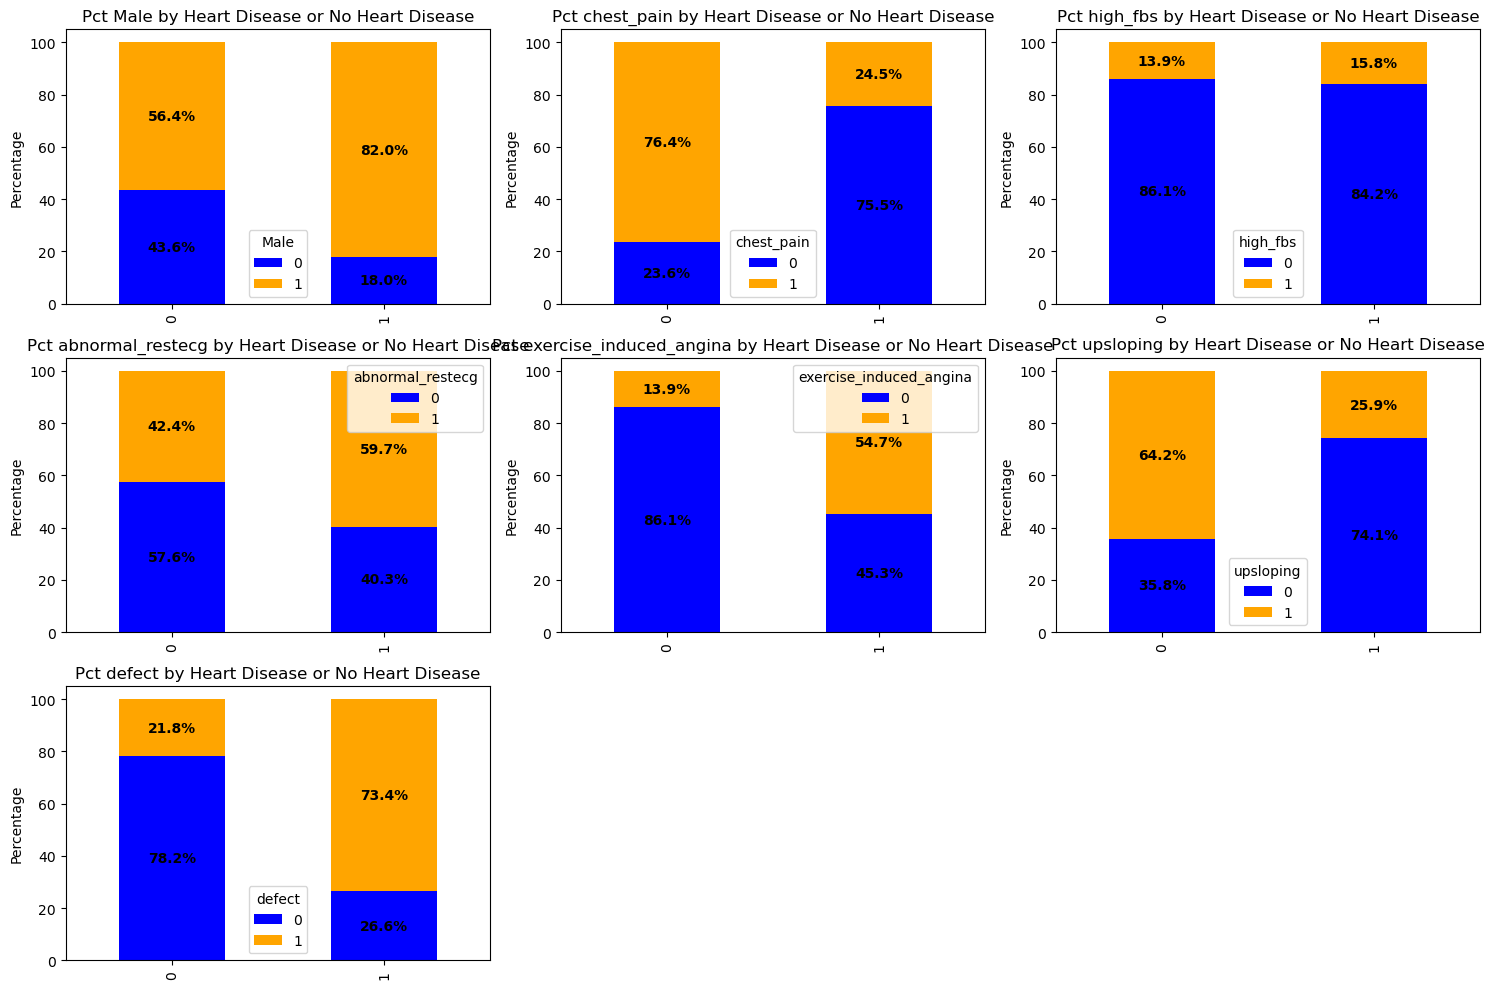

In [28]:
get_stacked_barcharts(cleveland_hd_data, ['Male', 'chest_pain', 'high_fbs', 'abnormal_restecg', 'exercise_induced_angina', 'upsloping', 'defect'])

### Chi-square tests of categorical variables ("Heart Disease" vs. "No Heart Disease")

In [29]:
bonferroni_correction = 7
for var in ['Male', 'chest_pain', 'high_fbs', 'abnormal_restecg', 'exercise_induced_angina', 'upsloping', 'defect']:
    get_chi_square(cleveland_hd_data, var, bonferroni_correction)

Male
chi2 = 21.681712248608402
p-value = 3.218449660997678e-06
adjusted p-value = 2.2529147626983745e-05

chest_pain
chi2 = 79.45402998813073
p-value = 4.93576970769024e-19
adjusted p-value = 3.4550387953831683e-18

high_fbs
chi2 = 0.08979976519544859
p-value = 0.7644318671680705
adjusted p-value = 5.351023070176494

abnormal_restecg
chi2 = 8.341421586674427
p-value = 0.0038751264478003983
adjusted p-value = 0.02712588513460279

exercise_induced_angina
chi2 = 55.171058420884066
p-value = 1.1048361290902256e-13
adjusted p-value = 7.73385290363158e-13

upsloping
chi2 = 43.03283954332243
p-value = 5.382869713772214e-11
adjusted p-value = 3.76800879964055e-10

defect
chi2 = 78.85460173981869
p-value = 6.685353505505068e-19
adjusted p-value = 4.679747453853547e-18



I conducted seven chi-squared tests to see if the number of responses in each category were different in the "Heart Disease" group vs. the "No Heart Disease" group. Because there were seven tests, I included an adjusted p-value that accounts for the increased chance of a false positive. Six of the seven variables had an adjusted p-value of less than .05 (high_fbs did not), and five of the seven had p-values of effectively 0 (Male, chest_pain, exercise_induced_angina, upsloping, and defect).

Because the high_fbs variable was clearly not significant, I am going to drop it from subsequent analyses.

In [30]:
all_hd_data = all_hd_data.drop(['high_fbs'], axis=1)
cleveland_hd_data = cleveland_hd_data.drop(['high_fbs'], axis=1)

### Correlation coefficients for categorical variables vs. target feature

In [31]:
print('Correlation coefficients - binary features')
for var in ['Male', 'chest_pain', 'abnormal_restecg', 'exercise_induced_angina', 'upsloping', 'defect']:
    get_correlation_coefficient(cleveland_hd_data, var)

Correlation coefficients - binary features
Correlation coefficient - Male and num: 0.27414380499183283
Correlation coefficient - chest_pain and num: -0.5178480063329011
Correlation coefficient - abnormal_restecg and num: 0.17225015856274375
Correlation coefficient - exercise_induced_angina and num: 0.433054393247803
Correlation coefficient - upsloping and num: -0.382855957663758
Correlation coefficient - defect and num: 0.5159349105037802


Looking at the correlation coefficients between the seven categorical variables and the target feature, we see positive correlations in five of the seven relationships (chest_pain and num and exercise_induced_angina and num being the only negative two). The strongest correlations are the same as what we've observed above (chest_pain, exercise_induced_angina, and defect).

## All variables

### Correlation coefficient heatmap

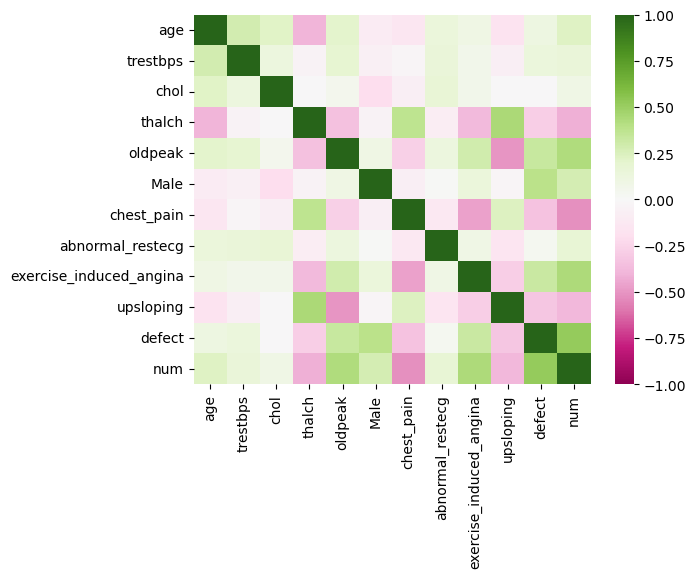

In [32]:
sns.heatmap(cleveland_hd_data[['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'Male', 'chest_pain',
                               'abnormal_restecg', 'exercise_induced_angina',  'upsloping', 
                               'defect', 'num']].corr(), 
            vmin=-1, vmax=1,cmap='PiYG');

The correlation coefficient heatmap highlights some of the observations from above. It also shows that some of our variables are not entirely independent of one another, which we might want to keep an eye on going forward.

# Save Datasets

In [33]:
all_hd_data.to_csv('..\data\interim\heart_disease_data_all_pt2.csv')
cleveland_hd_data.to_csv('..\data\interim\heart_disease_data_cleveland_pt2.csv')